In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import statsmodels.api as sm
import numpy as np
import mglearn 
from sklearn.cluster import KMeans

%matplotlib inline
import sklearn.model_selection as StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(15, 10))

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

In [2]:
import pyodbc 
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=SRVDWHBI;'
                      'Database=STAGING;'
                      'Trusted_Connection=yes;')

cursor = conn.cursor()
dataset = pd.read_sql_query("""SELECT * FROM STAGING..TEMP_ANALISIS_FRAUDE_EIS""",conn)

In [3]:
dataset['id_distribuidor'] = dataset['id_distribuidor'].astype('object')
dataset = dataset[dataset['cod_estado']=='A']
dataset.describe()

,edad_anios,vigencia_meses,level_1,tiempo_ult_solicitud,tiempo_ult_consumo,cantidad_clientes,cantidad_clientes_estafador,solicitudes_ingresadas,solicitudes_califica,solicitudes_aprobadas,...,monto_corriente,monto_vencido,monto_vencer,tasa_califica,tasa_aprobacion,tasa_negacion,tasa_consumo,comision_propia,comision_nivel,bonos
count,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,...,2408.00000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000
mean,31.973007,11.314369,2.938123,1.598007,290.064784,54.347591,0.009136,56.192691,37.801910,19.238787,...,26.54037,7668.705341,18279.262525,0.271793,0.133724,0.866276,0.173724,32.856106,25.730946,21.662095
std,10.534397,12.251909,7.291309,1.870648,452.575358,102.530521,0.103529,106.210189,64.091207,34.619180,...,137.94898,23141.987530,32973.927089,0.232778,0.134457,0.134457,0.197576,60.585062,133.862411,72.118802
min,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.00000,0.000000,0.000000,0.010417,0.000000,0.245888,0.000000,0.000000,0.000000,0.000000
25%,23.000000,5.000000,0.000000,0.000000,0.000000,4.000000,0.000000,5.000000,3.000000,1.000000,...,0.00000,0.000000,0.000000,0.083333,0.037037,0.808333,0.000000,0.000000,0.000000,0.000000
50%,30.000000,7.000000,0.000000,1.000000,1.000000,15.000000,0.000000,15.000000,11.000000,5.000000,...,0.00000,139.030000,4499.740000,0.173611,0.083333,0.916667,0.142857,7.398333,0.000000,0.000000
75%,39.000000,11.000000,2.000000,3.000000,999.000000,56.000000,0.000000,57.250000,40.250000,20.000000,...,0.00000,2304.357500,18435.457500,0.388889,0.191667,0.962963,0.250000,32.992292,0.000000,8.333333
max,72.000000,75.000000,83.000000,11.000000,999.000000,1362.000000,2.000000,1388.000000,567.000000,344.000000,...,1820.13000,301576.960000,230063.500000,0.989350,0.754112,1.000000,2.500000,443.420833,2866.670833,739.365150


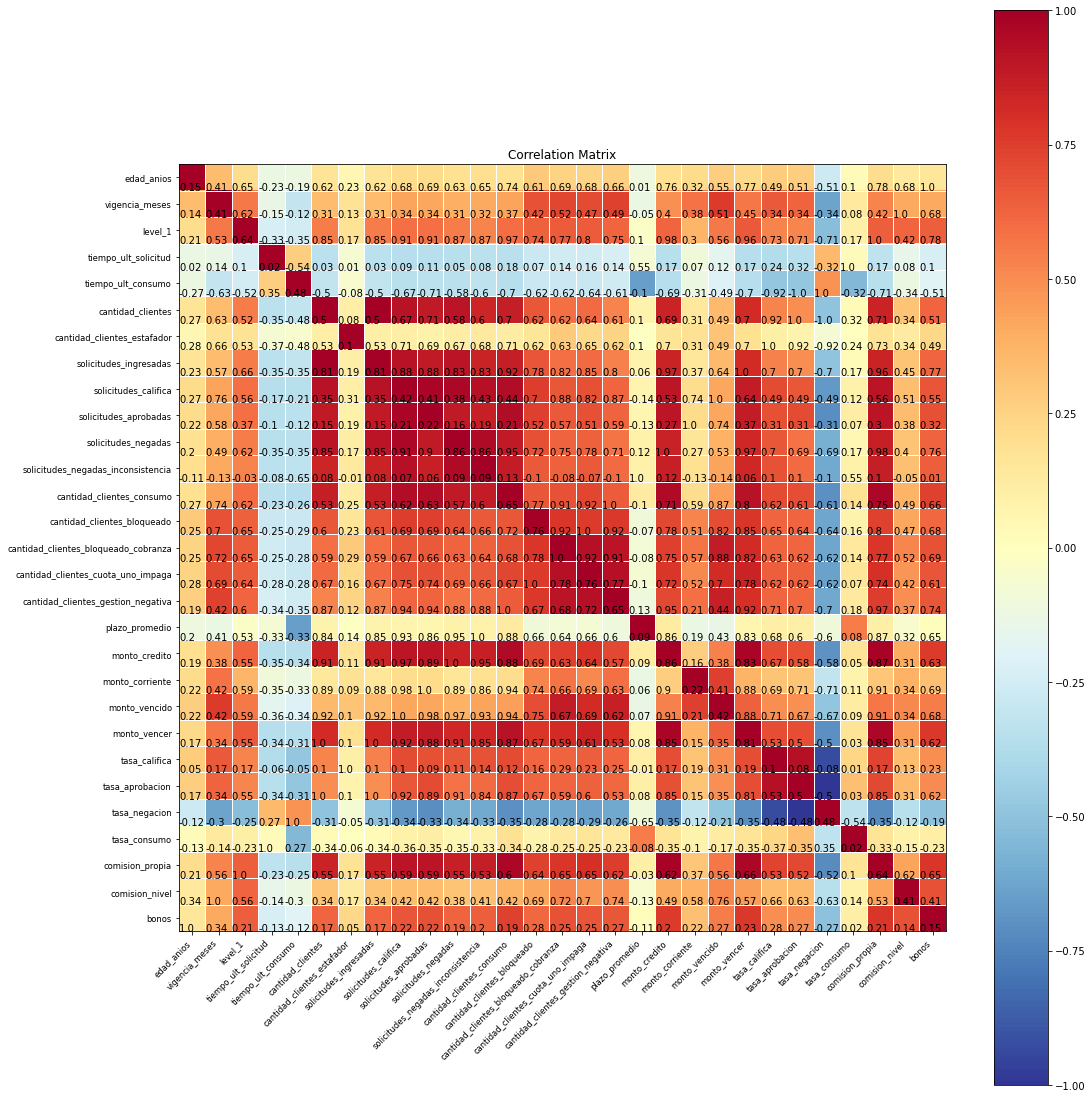

In [4]:
################################################
#MATRIZ CORRELACION DATASET ORIGINAL
################################################

plt.rcParams["figure.figsize"] = (16, 16)

corr = dataset.corr()
sm.graphics.plot_corr(corr, xnames=list(corr.columns))

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(i, j, round(corr.iloc[i,j], 2))

plt.show()


In [5]:
#Eliminar campos con correlacion baja en nuevo dataframe df
df = dataset.select_dtypes(include=['float64', 'int64'])

df= df.drop(['edad_anios','cantidad_clientes', 'tiempo_ult_solicitud','tiempo_ult_consumo','cantidad_clientes_estafador','plazo_promedio',
                     'tasa_consumo', 'tasa_aprobacion', 'tasa_negacion'],axis=1)
df.shape

(2408, 20)

In [6]:
################################################
#REDUCCIÓN DE DIMENSIONES PCA 
################################################

# You must normalize the data before applying the fit method
df_normalized=(df - df.mean()) / df.std()
pca = PCA(n_components=df.shape[1])
pca.fit(df_normalized)

# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=df.columns)
print(loadings)

#plt.plot(pca.explained_variance_ratio_)
#plt.ylabel('Explained Variance')
#plt.xlabel('Components')
#plt.show()

                                           PC0       PC1       PC2       PC3  \
vigencia_meses                        0.180872  0.324185 -0.247676 -0.444362   
level_1                               0.199665  0.110145  0.348663 -0.334564   
solicitudes_ingresadas                0.224989 -0.258292  0.005196  0.137951   
solicitudes_califica                  0.247105 -0.232902 -0.056790 -0.007831   
solicitudes_aprobadas                 0.243716 -0.214912 -0.035388  0.005196   
solicitudes_negadas                   0.234547 -0.253078 -0.062878 -0.012334   
solicitudes_negadas_inconsistencia    0.234595 -0.221026 -0.070036 -0.007531   
cantidad_clientes_consumo             0.247714 -0.208301  0.015486  0.027961   
cantidad_clientes_bloqueado           0.230670  0.104533 -0.134860  0.010647   
cantidad_clientes_bloqueado_cobranza  0.238460  0.211274 -0.062875  0.151175   
cantidad_clientes_cuota_uno_impaga    0.240547  0.171001 -0.091328  0.132685   
cantidad_clientes_gestion_negativa    0.

In [7]:
pca = PCA(n_components=2)
pca.fit(df)
#reduce a 2 dimenciones
transformada= pca.transform(df)
transformada.shape
dataset['id_distribuidor'].values

array([589, 837, 1132, ..., 15421, 15448, 15451], dtype=object)

Text(0, 0.5, 'PCA 2')

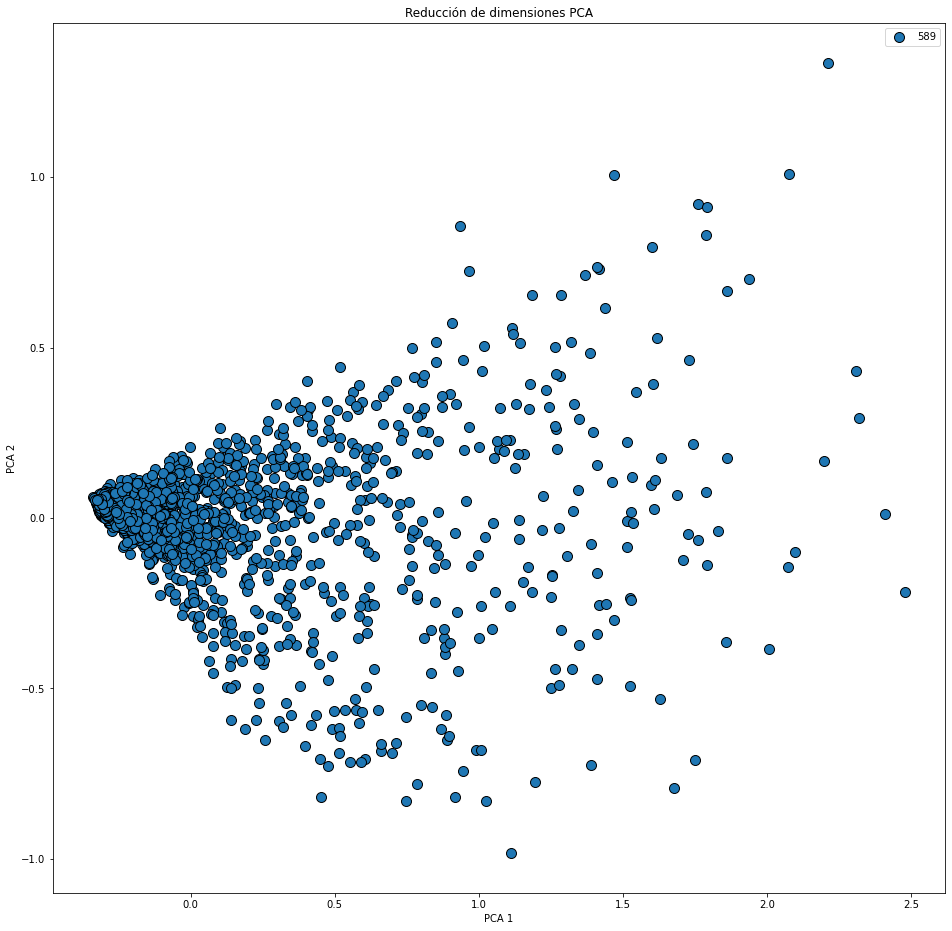

In [8]:
from sklearn.preprocessing import MinMaxScaler

escalar=MinMaxScaler()
escalar.fit(df)
escalada=escalar.transform(df)
pca.fit(escalada)
transformada=pca.transform(escalada)
mglearn.discrete_scatter(transformada[:,0], transformada[:,1])#, dataset['id_distribuidor'] )
plt.legend(dataset['id_distribuidor'].unique(), loc='best')
plt.title('Reducción de dimensiones PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

In [9]:
df.describe()

,vigencia_meses,level_1,solicitudes_ingresadas,solicitudes_califica,solicitudes_aprobadas,solicitudes_negadas,solicitudes_negadas_inconsistencia,cantidad_clientes_consumo,cantidad_clientes_bloqueado,cantidad_clientes_bloqueado_cobranza,cantidad_clientes_cuota_uno_impaga,cantidad_clientes_gestion_negativa,monto_credito,monto_corriente,monto_vencido,monto_vencer,tasa_califica,comision_propia,comision_nivel,bonos
count,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.00000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000
mean,11.314369,2.938123,56.192691,37.801910,19.238787,17.103821,5.215116,10.351744,6.397425,2.117525,2.879568,2.999169,15337.908796,26.54037,7668.705341,18279.262525,0.271793,32.856106,25.730946,21.662095
std,12.251909,7.291309,106.210189,64.091207,34.619180,28.689287,9.248554,18.740405,13.778180,4.725702,6.373732,7.388388,27684.031214,137.94898,23141.987530,32973.927089,0.232778,60.585062,133.862411,72.118802
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.010417,0.000000,0.000000,0.000000
25%,5.000000,0.000000,5.000000,3.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000
50%,7.000000,0.000000,15.000000,11.000000,5.000000,5.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,3811.055000,0.00000,139.030000,4499.740000,0.173611,7.398333,0.000000,0.000000
75%,11.000000,2.000000,57.250000,40.250000,20.000000,19.000000,6.000000,11.000000,6.000000,2.000000,2.000000,2.000000,15728.725000,0.00000,2304.357500,18435.457500,0.388889,32.992292,0.000000,8.333333
max,75.000000,83.000000,1388.000000,567.000000,344.000000,298.000000,86.000000,154.000000,155.000000,44.000000,52.000000,70.000000,232665.020000,1820.13000,301576.960000,230063.500000,0.989350,443.420833,2866.670833,739.365150


In [10]:
#Estadarizar dataframe
df[df.columns] = escalar.fit_transform(df[df.columns])
df

,vigencia_meses,level_1,solicitudes_ingresadas,solicitudes_califica,solicitudes_aprobadas,solicitudes_negadas,solicitudes_negadas_inconsistencia,cantidad_clientes_consumo,cantidad_clientes_bloqueado,cantidad_clientes_bloqueado_cobranza,cantidad_clientes_cuota_uno_impaga,cantidad_clientes_gestion_negativa,monto_credito,monto_corriente,monto_vencido,monto_vencer,tasa_califica,comision_propia,comision_nivel,bonos
1,0.093333,0.012048,0.080750,0.146643,0.133721,0.110738,0.162791,0.149351,0.038710,0.000000,0.019231,0.014286,0.139806,0.000000,0.004777,0.158415,0.308571,0.145244,0.000000,0.039448
3,0.933333,0.120482,0.123288,0.245583,0.203488,0.171141,0.197674,0.110390,0.496774,0.477273,0.346154,0.428571,0.230891,0.673243,0.440883,0.339103,0.777574,0.307466,0.041232,0.085659
4,0.053333,0.012048,0.011536,0.024735,0.017442,0.030201,0.023256,0.006494,0.083871,0.250000,0.326923,0.371429,0.034628,0.206831,0.300791,0.096055,0.147452,0.017651,0.000000,0.004508
5,0.053333,0.000000,0.000721,0.001767,0.000000,0.006711,0.011628,0.000000,0.019355,0.000000,0.038462,0.042857,0.006373,0.073841,0.017383,0.048724,0.159613,0.006829,0.000000,0.000000
9,0.426667,0.566265,0.153569,0.300353,0.328488,0.177852,0.116279,0.435065,0.187097,0.204545,0.365385,0.142857,0.298245,0.000000,0.120942,0.369913,0.564256,0.413225,0.007710,0.137505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3951,0.026667,0.000000,0.000000,0.000000,0.002907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.074486,0.000000,0.000000,0.000000
3952,0.026667,0.000000,0.005768,0.008834,0.011628,0.006711,0.000000,0.000000,0.006452,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046110,0.000000,0.000000,0.000000
3953,0.026667,0.000000,0.000000,0.000000,0.000000,0.003356,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.074486,0.000000,0.000000,0.000000
3954,0.026667,0.012048,0.005768,0.005300,0.005814,0.006711,0.000000,0.000000,0.006452,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027193,0.000000,0.000000,0.000000


In [11]:
df.columns

Index(['vigencia_meses', 'level_1', 'solicitudes_ingresadas',
       'solicitudes_califica', 'solicitudes_aprobadas', 'solicitudes_negadas',
       'solicitudes_negadas_inconsistencia', 'cantidad_clientes_consumo',
       'cantidad_clientes_bloqueado', 'cantidad_clientes_bloqueado_cobranza',
       'cantidad_clientes_cuota_uno_impaga',
       'cantidad_clientes_gestion_negativa', 'monto_credito',
       'monto_corriente', 'monto_vencido', 'monto_vencer', 'tasa_califica',
       'comision_propia', 'comision_nivel', 'bonos'],
      dtype='object')

Text(0.5, 1.0, 'MATRIZ DE CORRELACION VARIABLES')

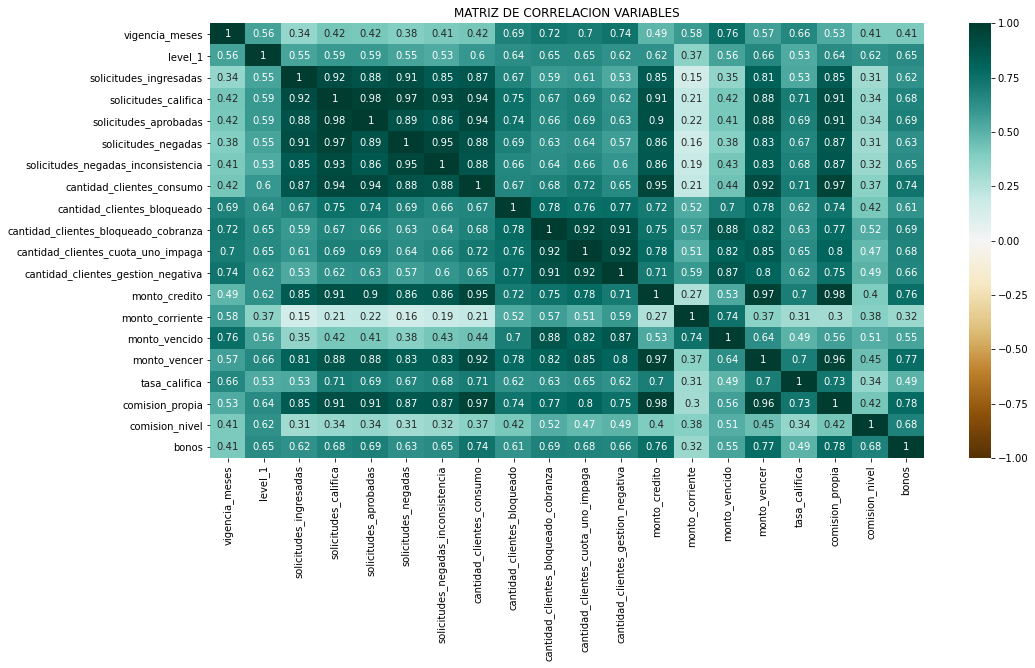

In [12]:
plt.figure(figsize=(16, 8))
#cmap = sns.cubehelix_palette(start = 1, rot = 3, gamma=0.8, as_cmap = True)   
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')#, linewidths = 0.05, linecolor= 'red', ax = ax)   
heatmap.set_title('MATRIZ DE CORRELACION VARIABLES')
#heatmap.set_xlabel('region')


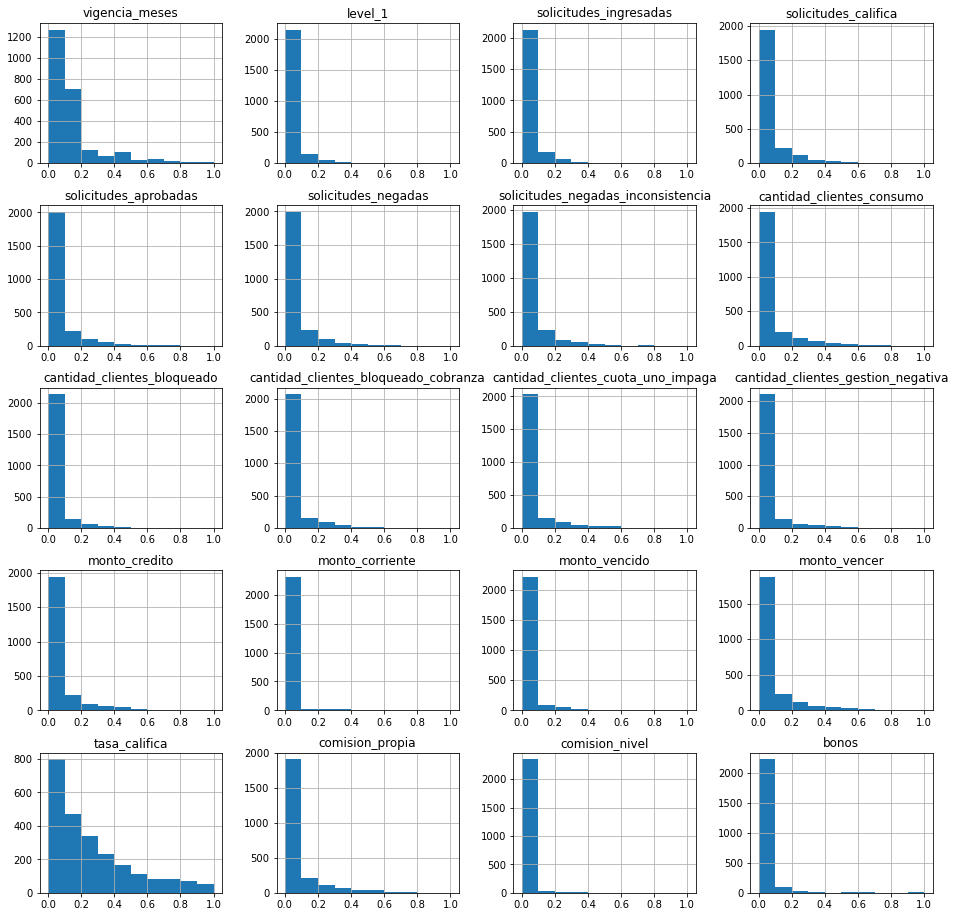

In [13]:
####################################################3
#DISTRIBUCION DE LOS DATOS
####################################################

#plt.figure(figsize=(15, 10))
#df.drop(['tasa_califica'],1).hist()
#df[['monto_credito','monto_corriente', 'monto_vencido', 'monto_vencer']].hist()
plt.rcParams["figure.figsize"] = (16, 16)
df.hist()

#plt.title('DISTRIBUCIÓN DE LOS DATOS')
plt.show()

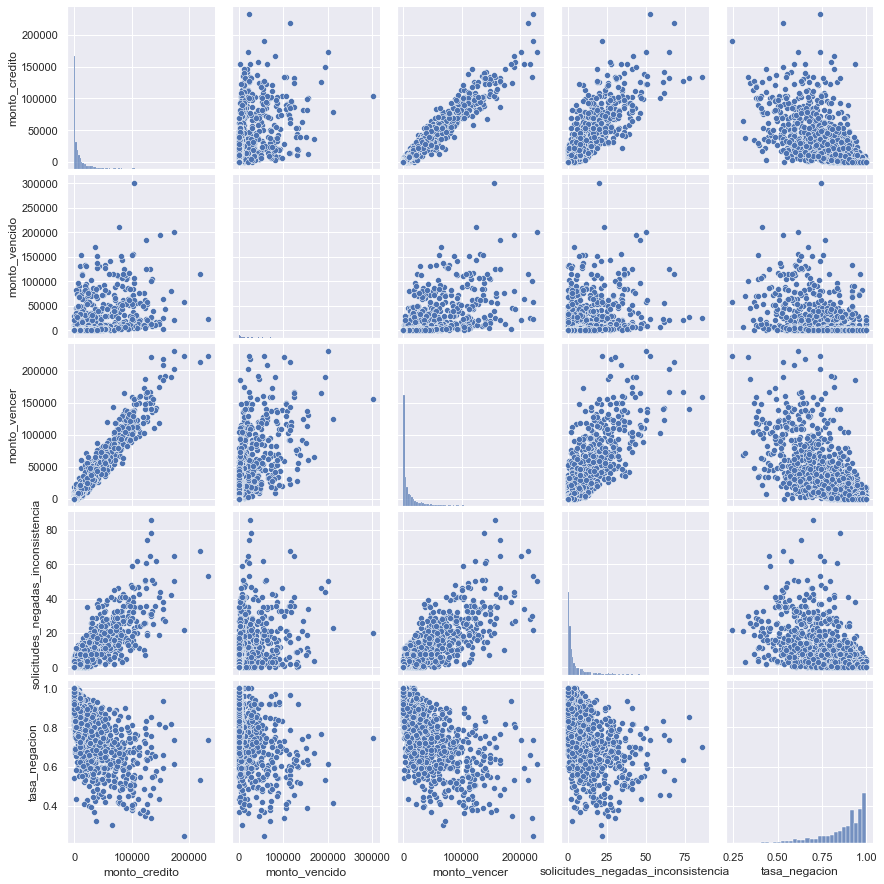

In [14]:
####################################
#CORRELACION ENTRE VARIABLES
##########################################
sns.set()
#cols = ["solicitudes_negadas_inconsistencia","monto_vencido","cantidad_clientes_bloqueado","tasa_negacion"]
cols = ["monto_credito","monto_vencido","monto_vencer","solicitudes_negadas_inconsistencia",'tasa_negacion']
sns.pairplot(dataset[cols], height = 2.5)
plt.show();

In [15]:
X = np.array(df.values)
X

array([[9.33333333e-02, 1.20481928e-02, 8.07498198e-02, ...,
        1.45243890e-01, 0.00000000e+00, 3.94482573e-02],
       [9.33333333e-01, 1.20481928e-01, 1.23287671e-01, ...,
        3.07465632e-01, 4.12316261e-02, 8.56590730e-02],
       [5.33333333e-02, 1.20481928e-02, 1.15356885e-02, ...,
        1.76506517e-02, 0.00000000e+00, 4.50837226e-03],
       ...,
       [2.66666667e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.66666667e-02, 1.20481928e-02, 5.76784427e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.66666667e-02, 0.00000000e+00, 7.20980534e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

#############KMENs FOCALIZADO
#X = np.array(dataset[["solicitudes_negadas_inconsistencia","monto_vencido","cantidad_clientes_bloqueado"]])
X = np.array(dataset[["monto_vencido","monto_vencer","solicitudes_negadas_inconsistencia"]])

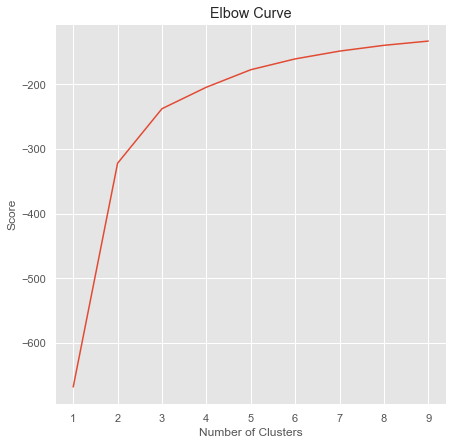

In [39]:
plt.rcParams["figure.figsize"] = (7, 7)

Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [40]:

kmeans = KMeans(n_clusters=3).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[8.77684407e-02 7.41790692e-03 1.27615574e-02 1.97622512e-02
  1.68669793e-02 2.01586675e-02 1.93798450e-02 1.75379243e-02
  1.00153610e-02 8.53068500e-03 9.02822668e-03 5.48219288e-03
  1.68381792e-02 1.14801108e-03 2.93447796e-03 2.01436141e-02
  1.52335795e-01 1.65769951e-02 2.90950655e-04 3.20192356e-03]
 [4.41307190e-01 2.37184030e-01 2.36222439e-01 3.88992817e-01
  3.45113239e-01 3.11795412e-01 3.46101231e-01 4.23181394e-01
  2.84250474e-01 3.49376114e-01 3.98818502e-01 3.29131653e-01
  4.25653933e-01 1.15037140e-01 1.94111559e-01 5.21517874e-01
  7.38662496e-01 4.97591825e-01 8.87031276e-02 3.05493056e-01]
 [2.95914894e-01 7.59805178e-02 7.85101781e-02 1.31445004e-01
  1.10131123e-01 1.16000286e-01 1.24418605e-01 1.40024869e-01
  8.08922443e-02 1.00435203e-01 1.19599018e-01 9.15501520e-02
  1.35235501e-01 3.28990646e-02 5.59471497e-02 1.60796858e-01
  5.48944021e-01 1.54689010e-01 1.60064630e-02 3.84984745e-02]]


ValueError: 'c' argument has 4 elements, which is inconsistent with 'x' and 'y' with size 3.

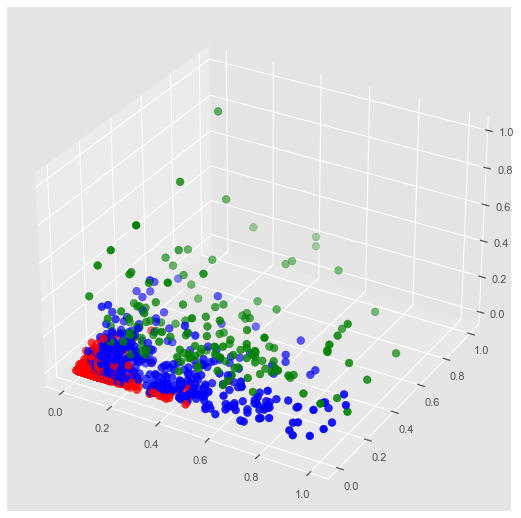

In [41]:

# Predicting the clusters
labels = kmeans.predict(X)

# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue','yellow'] #'cyan',
asignar=[]
for row in labels:
    asignar.append(colores[row])
 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

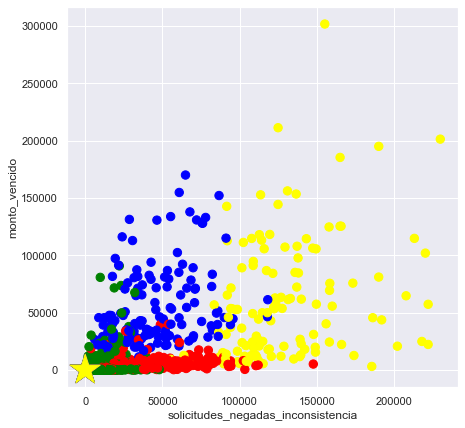

In [19]:
f1 = dataset["monto_vencer"].values
f2 = dataset['monto_vencido'].values
 
plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)
plt.xlabel('solicitudes_negadas_inconsistencia')
plt.ylabel('monto_vencido')
plt.show()

In [20]:
#sns.displot(df['tasa_negacion']);
#labels = kmeans.labels_


In [42]:
# standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)



# statistics of scaled data
pd.DataFrame(data_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
count,2.408000e+03,2.408000e+03,2.408000e+03,2.408000e+03,2.408000e+03,2.408000e+03,2.408000e+03,2.408000e+03,2.408000e+03,2.408000e+03,...,2.408000e+03,2.408000e+03,2.408000e+03,2.408000e+03,2.408000e+03,2.408000e+03,2.408000e+03,2.408000e+03,2.408000e+03,2.408000e+03
mean,5.266182e-16,-2.220331e-15,-4.470861e-16,2.395371e-15,-1.369060e-15,-7.003257e-15,1.112344e-15,-4.945472e-15,2.058016e-15,-7.640667e-15,...,-3.825982e-15,3.747372e-15,2.698953e-15,-3.257453e-15,-1.383445e-15,1.740118e-15,3.010051e-15,9.647829e-16,-9.429058e-16,1.142465e-14
std,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,...,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00
min,-9.236698e-01,-4.030461e-01,-5.197633e-01,-5.743308e-01,-5.558417e-01,-5.962983e-01,-5.640016e-01,-5.524904e-01,-4.644121e-01,-4.481800e-01,...,-4.060144e-01,-5.541496e-01,-1.924326e-01,-3.314451e-01,-5.544702e-01,-1.123087e+00,-5.424263e-01,-1.922593e-01,-3.004292e-01,-4.928089e-01
25%,-5.154854e-01,-4.030461e-01,-4.820943e-01,-5.431188e-01,-5.269500e-01,-5.265714e-01,-5.640016e-01,-5.524904e-01,-4.644121e-01,-4.481800e-01,...,-4.060144e-01,-5.541496e-01,-1.924326e-01,-3.314451e-01,-5.544702e-01,-8.097771e-01,-5.424263e-01,-1.922593e-01,-3.004292e-01,-4.928089e-01
50%,-3.522116e-01,-4.030461e-01,-3.879218e-01,-4.182708e-01,-4.113831e-01,-4.219810e-01,-3.477067e-01,-3.923753e-01,-3.918185e-01,-4.481800e-01,...,-4.060144e-01,-4.164584e-01,-1.924326e-01,-3.254361e-01,-4.179783e-01,-4.218693e-01,-4.202861e-01,-1.922593e-01,-3.004292e-01,-4.928089e-01
75%,-2.566409e-02,-1.286899e-01,9.956941e-03,3.820490e-02,2.199274e-02,6.610737e-02,8.488318e-02,3.459853e-02,-2.885053e-02,-2.487447e-02,...,-1.352632e-01,1.411996e-02,-1.924326e-01,-2.318497e-01,4.737908e-03,5.031417e-01,2.248303e-03,-1.922593e-01,-1.848551e-01,-4.928089e-01
max,5.199097e+00,1.098273e+01,1.254196e+01,8.258668e+00,9.382911e+00,9.793012e+00,8.736680e+00,7.666755e+00,1.078760e+01,8.864541e+00,...,9.070279e+00,7.851900e+00,1.300453e+01,1.270285e+01,6.424113e+00,3.083216e+00,6.778074e+00,2.122724e+01,9.953745e+00,2.288481e+00


In [44]:
# defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=3, init='k-means++')

# fitting the k means algorithm on scaled data
kmeans.fit(data_scaled)
kmeans.inertia_
# inertia on the fitted data
pred = kmeans.predict(data_scaled)

In [23]:
dataset.shape

(2408, 40)

In [45]:
dataset['target'] = pred
dataset['target'].value_counts()
dataset

,fecha_proceso,id_distribuidor,des_sexo,num_identificacion,des_estado_civil,des_almacen,cod_estado,fecha_ingreso,fecha_baja,edad_anios,...,monto_vencido,monto_vencer,tasa_califica,tasa_aprobacion,tasa_negacion,tasa_consumo,comision_propia,comision_nivel,bonos,target
1,2021-01-01,589,MASCULINO,0911339455,CASADO,MALL DEL SUR,A,2021-07-28 15:28:00,1900-01-01,53,...,1440.55,36445.40,0.312487,0.168549,0.831451,0.203540,64.404167,0.000000,29.166667,2
3,2021-01-01,837,FEMENINO,0914668702,CASADO,CALIFORNIA,A,2016-04-01 00:00:00,1900-01-01,52,...,132960.11,78015.14,0.771609,0.400760,0.599240,0.098837,136.336667,118.197500,63.333333,1
4,2021-01-01,1132,MASCULINO,0917741498,SOLTERO,CASUARINA,A,2021-10-12 00:38:00,1900-01-01,46,...,90711.64,22098.85,0.154762,0.079365,0.920635,0.058824,7.826667,0.000000,3.333333,0
5,2021-01-01,1169,MASCULINO,0918132556,SOLTERO,MALL DEL SUR,A,2021-10-13 00:58:00,1900-01-01,38,...,5242.44,11209.71,0.166667,0.000000,1.000000,0.000000,3.028333,0.000000,0.000000,0
9,2021-01-01,4009,FEMENINO,1350756324,SOLTERO,PORTOVIEJO 2,A,2019-06-18 00:00:00,1900-01-01,24,...,36473.28,85103.45,0.562785,0.333176,0.666824,0.313084,183.232500,22.101667,101.666667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3951,2021-01-01,15327,FEMENINO,0604619775,SOLTERO,EL RECREO,A,2021-12-08 17:38:00,1900-01-01,34,...,0.00,0.00,0.083333,0.083333,0.916667,0.000000,0.000000,0.000000,0.000000,0
3952,2021-01-01,15397,MASCULINO,1802046837,CASADO,AMBATO,A,2021-12-14 11:18:00,1900-01-01,57,...,0.00,0.00,0.055556,0.037037,0.962963,0.000000,0.000000,0.000000,0.000000,0
3953,2021-01-01,15421,FEMENINO,0957327224,SOLTERO,9 DE OCTUBRE 1,A,2021-12-16 14:08:00,1900-01-01,21,...,0.00,0.00,0.083333,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0
3954,2021-01-01,15448,MASCULINO,0927998468,SOLTERO,MILAGRO,A,2021-12-20 15:28:00,1900-01-01,19,...,0.00,0.00,0.037037,0.018519,0.981481,0.000000,0.000000,0.000000,0.000000,0


In [46]:
df['target'] = pred
df['target'].value_counts()
df

,vigencia_meses,level_1,solicitudes_ingresadas,solicitudes_califica,solicitudes_aprobadas,solicitudes_negadas,solicitudes_negadas_inconsistencia,cantidad_clientes_consumo,cantidad_clientes_bloqueado,cantidad_clientes_bloqueado_cobranza,...,cantidad_clientes_gestion_negativa,monto_credito,monto_corriente,monto_vencido,monto_vencer,tasa_califica,comision_propia,comision_nivel,bonos,target
1,0.093333,0.012048,0.080750,0.146643,0.133721,0.110738,0.162791,0.149351,0.038710,0.000000,...,0.014286,0.139806,0.000000,0.004777,0.158415,0.308571,0.145244,0.000000,0.039448,2
3,0.933333,0.120482,0.123288,0.245583,0.203488,0.171141,0.197674,0.110390,0.496774,0.477273,...,0.428571,0.230891,0.673243,0.440883,0.339103,0.777574,0.307466,0.041232,0.085659,1
4,0.053333,0.012048,0.011536,0.024735,0.017442,0.030201,0.023256,0.006494,0.083871,0.250000,...,0.371429,0.034628,0.206831,0.300791,0.096055,0.147452,0.017651,0.000000,0.004508,0
5,0.053333,0.000000,0.000721,0.001767,0.000000,0.006711,0.011628,0.000000,0.019355,0.000000,...,0.042857,0.006373,0.073841,0.017383,0.048724,0.159613,0.006829,0.000000,0.000000,0
9,0.426667,0.566265,0.153569,0.300353,0.328488,0.177852,0.116279,0.435065,0.187097,0.204545,...,0.142857,0.298245,0.000000,0.120942,0.369913,0.564256,0.413225,0.007710,0.137505,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3951,0.026667,0.000000,0.000000,0.000000,0.002907,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.074486,0.000000,0.000000,0.000000,0
3952,0.026667,0.000000,0.005768,0.008834,0.011628,0.006711,0.000000,0.000000,0.006452,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.046110,0.000000,0.000000,0.000000,0
3953,0.026667,0.000000,0.000000,0.000000,0.000000,0.003356,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.074486,0.000000,0.000000,0.000000,0
3954,0.026667,0.012048,0.005768,0.005300,0.005814,0.006711,0.000000,0.000000,0.006452,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.027193,0.000000,0.000000,0.000000,0


0    1887
1     134
2     387
Name: target, dtype: int64


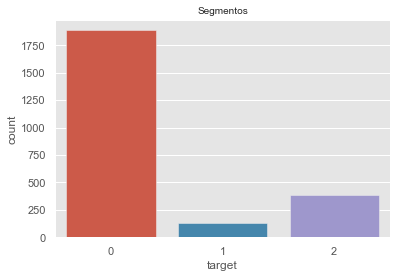

In [47]:
# Segmentos
fig, ax = plt.subplots(figsize=(6,4))
plt.title('Segmentos', fontsize = 'medium')
sns.countplot(data = df, x='target')
print(df.target.value_counts().sort_index())

In [48]:
df.columns

Index(['vigencia_meses', 'level_1', 'solicitudes_ingresadas',
       'solicitudes_califica', 'solicitudes_aprobadas', 'solicitudes_negadas',
       'solicitudes_negadas_inconsistencia', 'cantidad_clientes_consumo',
       'cantidad_clientes_bloqueado', 'cantidad_clientes_bloqueado_cobranza',
       'cantidad_clientes_cuota_uno_impaga',
       'cantidad_clientes_gestion_negativa', 'monto_credito',
       'monto_corriente', 'monto_vencido', 'monto_vencer', 'tasa_califica',
       'comision_propia', 'comision_nivel', 'bonos', 'target'],
      dtype='object')

In [49]:
dataGrupo= df.groupby('target').agg({ 
'solicitudes_ingresadas': [np.mean],
'solicitudes_califica': [np.mean],
'solicitudes_aprobadas': [np.mean],
'solicitudes_negadas': [np.mean],
'solicitudes_negadas_inconsistencia': [np.mean],
'cantidad_clientes_consumo': [np.mean],
'cantidad_clientes_bloqueado': [np.mean],
'cantidad_clientes_bloqueado_cobranza': [np.mean],
'cantidad_clientes_cuota_uno_impaga': [np.mean],
'cantidad_clientes_gestion_negativa': [np.mean],
'monto_credito': [np.mean],
'monto_corriente': [np.mean],
'monto_vencido': [np.mean],
'monto_vencer': [np.mean],
'monto_vencer': [np.mean],
'comision_nivel': [np.mean],
     'comision_propia': [np.mean],
'bonos': [np.mean]  
})

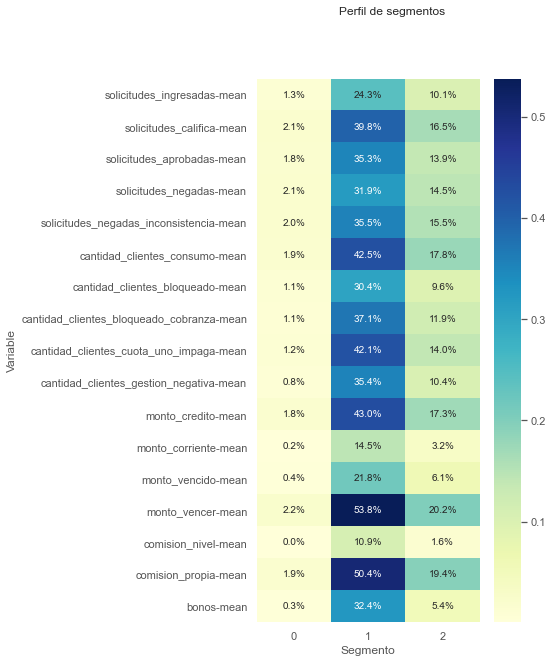

In [51]:
fig, ax = plt.subplots(figsize=(5,10))
_=sns.heatmap(np.transpose(dataGrupo) ,annot=True,fmt=".1%",cmap="YlGnBu",
xticklabels = ["0","1","2"])#
_=plt.yticks(rotation=0)
_=plt.xlabel("Segmento")
_=plt.ylabel("Variable")
_=plt.suptitle("Perfil de segmentos")

In [30]:
df.columns

Index(['vigencia_meses', 'level_1', 'solicitudes_ingresadas',
       'solicitudes_califica', 'solicitudes_aprobadas', 'solicitudes_negadas',
       'solicitudes_negadas_inconsistencia', 'cantidad_clientes_consumo',
       'cantidad_clientes_bloqueado', 'cantidad_clientes_bloqueado_cobranza',
       'cantidad_clientes_cuota_uno_impaga',
       'cantidad_clientes_gestion_negativa', 'monto_credito',
       'monto_corriente', 'monto_vencido', 'monto_vencer', 'tasa_califica',
       'comision_propia', 'comision_nivel', 'bonos', 'target'],
      dtype='object')

In [52]:
print("Riesgo Alto: ",len(dataset[dataset['target']==1]))
print('Riesgo medio : ',len(dataset[dataset['target']==2]))
print("Riesgo bajo: ",len(dataset[dataset['target']==0]))

Riesgo Alto:  134
Riesgo medio :  387
Riesgo bajo:  1887


In [53]:
data1 = dataset
data1['target'] = data1['target'].astype('object')


In [55]:
data1[['monto_vencer', 'monto_vencido','target']].groupby(['target']).agg(["mean","median","count"])
#.sort_values(by = 'target', ascending = True)

monto_credito                 monto_vencido                 
                 mean    median count          mean     median count
target                                                              
0         4232.406868   1764.41  1887   1334.857870      0.000  1887
1       100109.055299  97737.70   134  65787.729925  54936.415   134
2        40135.708553  35129.80   387  18428.449225   5886.210   387

In [57]:
data1[[ 'cantidad_clientes_bloqueado', 'cantidad_clientes_bloqueado_cobranza',
       'cantidad_clientes_cuota_uno_impaga','cantidad_clientes_gestion_negativa','target']].groupby(['target']).agg(["mean","median","count"])
#.sort_values(by = 'target', ascending = True)

cantidad_clientes_bloqueado               \
                              mean median count   
target                                            
0                         1.756227    1.0  1887   
1                        47.164179   40.5   134   
2                        14.912145   12.0   387   

       cantidad_clientes_bloqueado_cobranza               \
                                       mean median count   
target                                                     
0                                  0.467939      0  1887   
1                                 16.320896     15   134   
2                                  5.242894      4   387   

       cantidad_clientes_cuota_uno_impaga               \
                                     mean median count   
target                                                   
0                                0.623741      0  1887   
1                               21.895522     21   134   
2                                7.294574      6   387   

       cantidad_clientes_gestion_negativa               
                                     mean median count  
target                                                  
0                                0.579756      0  1887  
1                               24.753731     23   134  
2                                7.263566      5   387

In [58]:
#vista = dataset[dataset['target']!=0]
vista = dataset

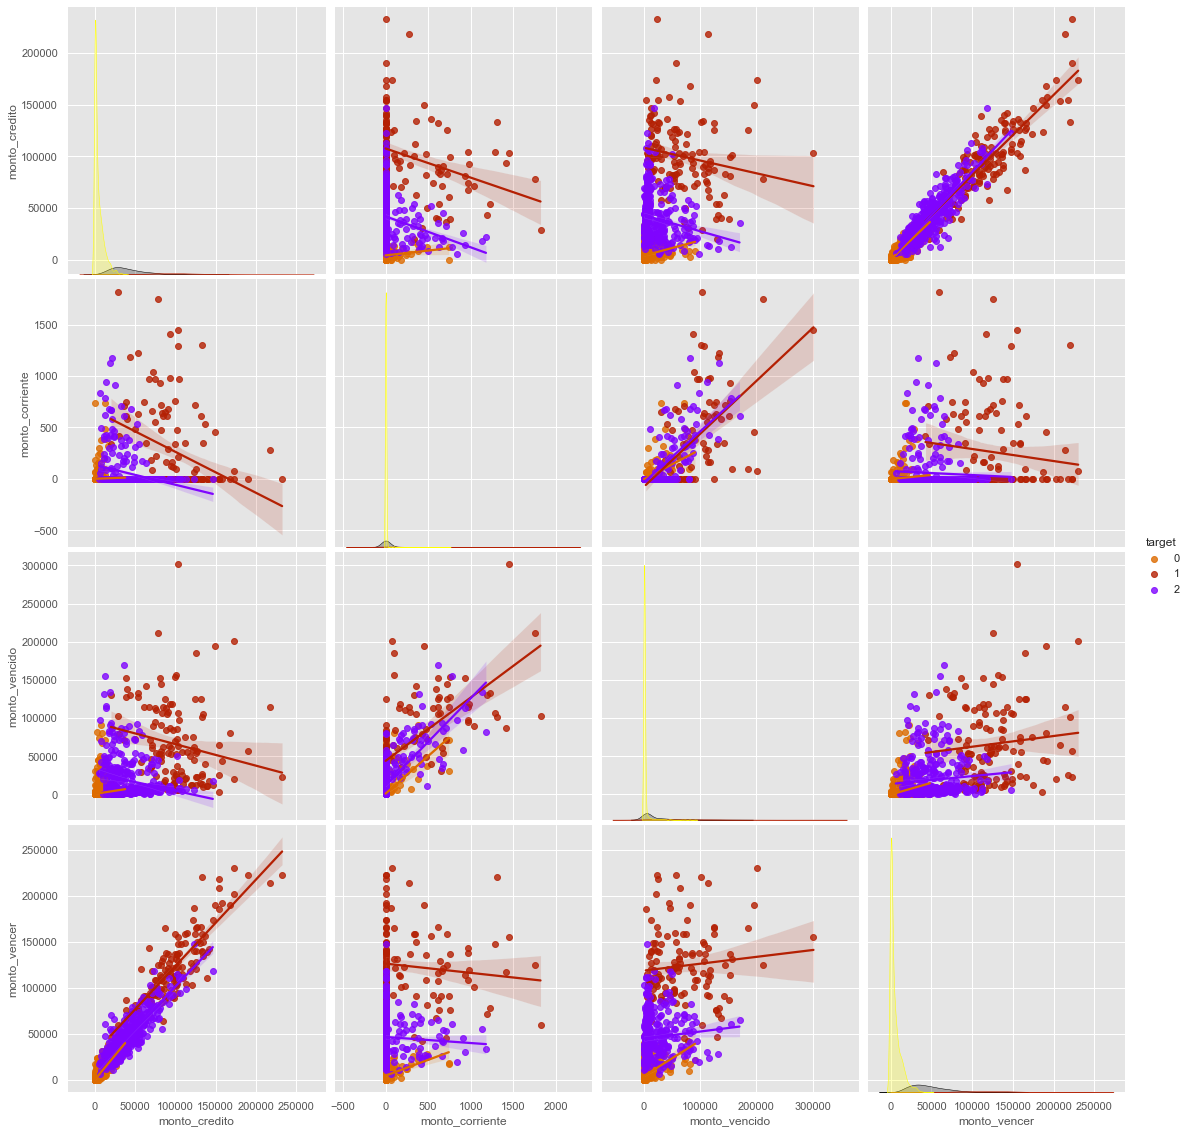

In [59]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
sns.pairplot(vista.dropna(), hue='target',
             height=4,
             vars=['monto_credito','monto_corriente', 'monto_vencido', 'monto_vencer'],
             kind='reg',
             palette='gnuplot_r')

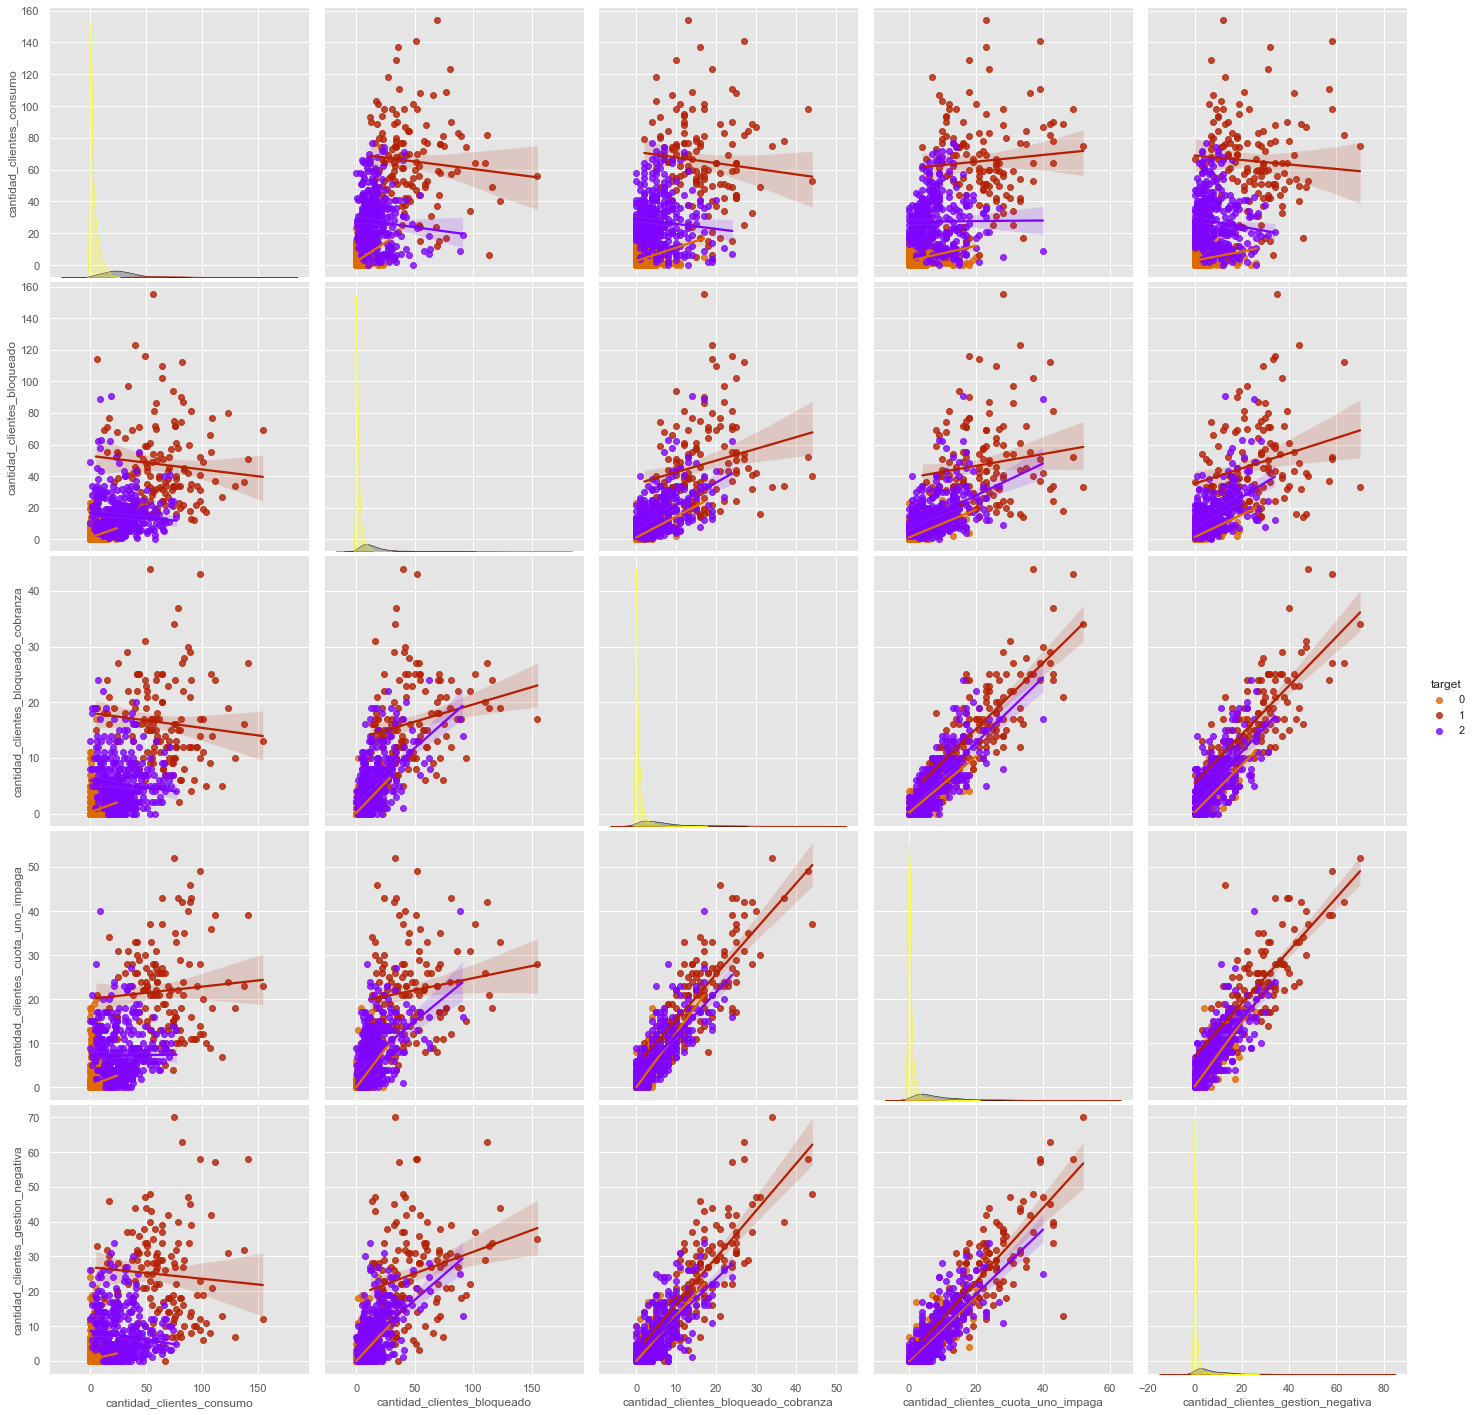

In [60]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
sns.pairplot(vista.dropna(), hue='target',
             height=4,
             vars=['cantidad_clientes_consumo',
       'cantidad_clientes_bloqueado', 'cantidad_clientes_bloqueado_cobranza',
       'cantidad_clientes_cuota_uno_impaga',
       'cantidad_clientes_gestion_negativa'],
             kind='reg',
             palette='gnuplot_r')

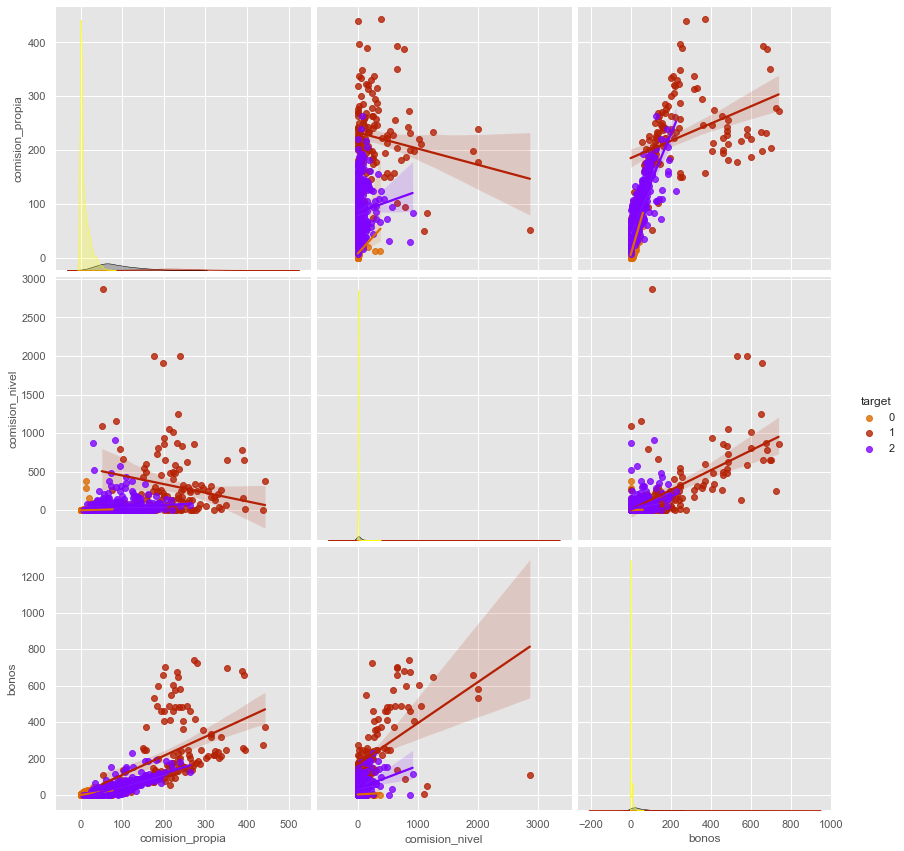

In [61]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
sns.pairplot(vista.dropna(), hue='target',
             height=4,
             vars=['comision_propia', 'comision_nivel', 'bonos'],
             kind='reg',
             palette='gnuplot_r')

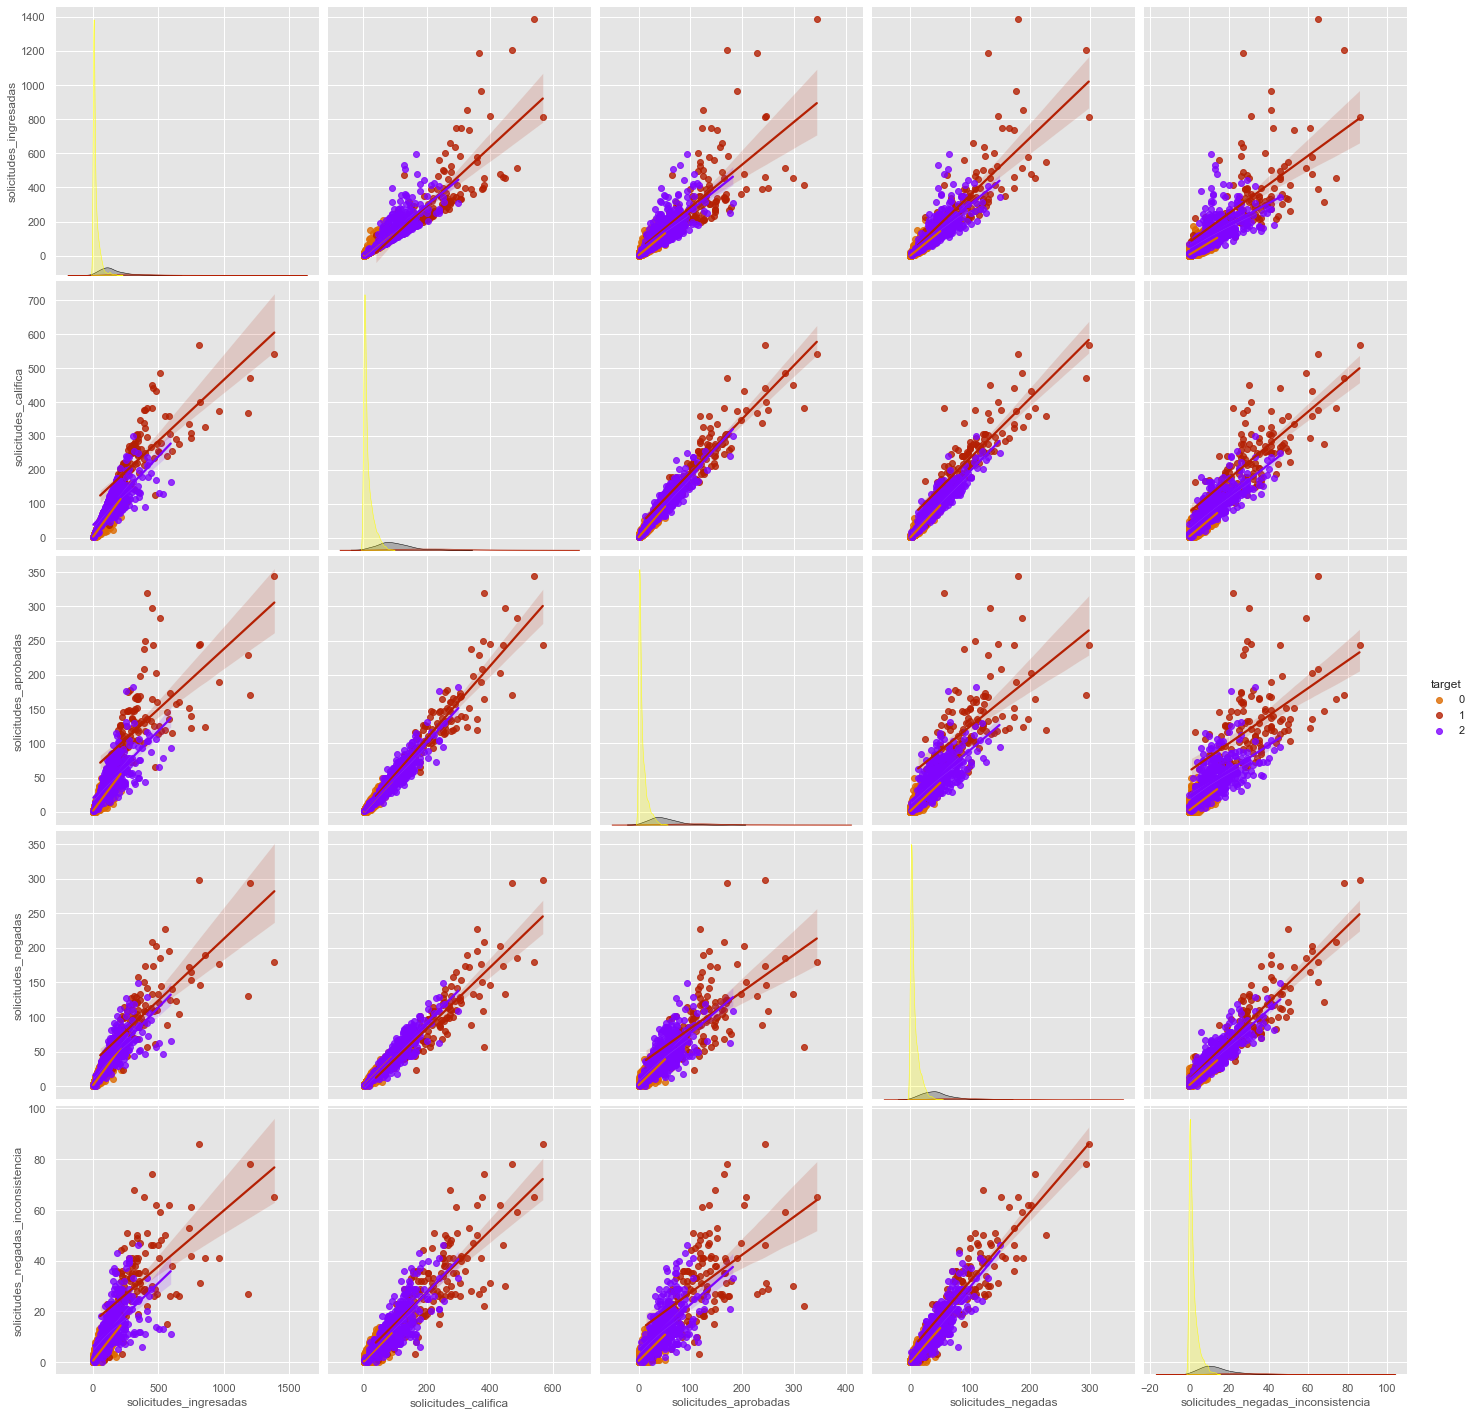

In [62]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
sns.pairplot(vista.dropna(), hue='target',
             height=4,
             vars=['solicitudes_ingresadas','solicitudes_califica', 'solicitudes_aprobadas', 'solicitudes_negadas',
       'solicitudes_negadas_inconsistencia'],
             kind='reg',
             palette='gnuplot_r')

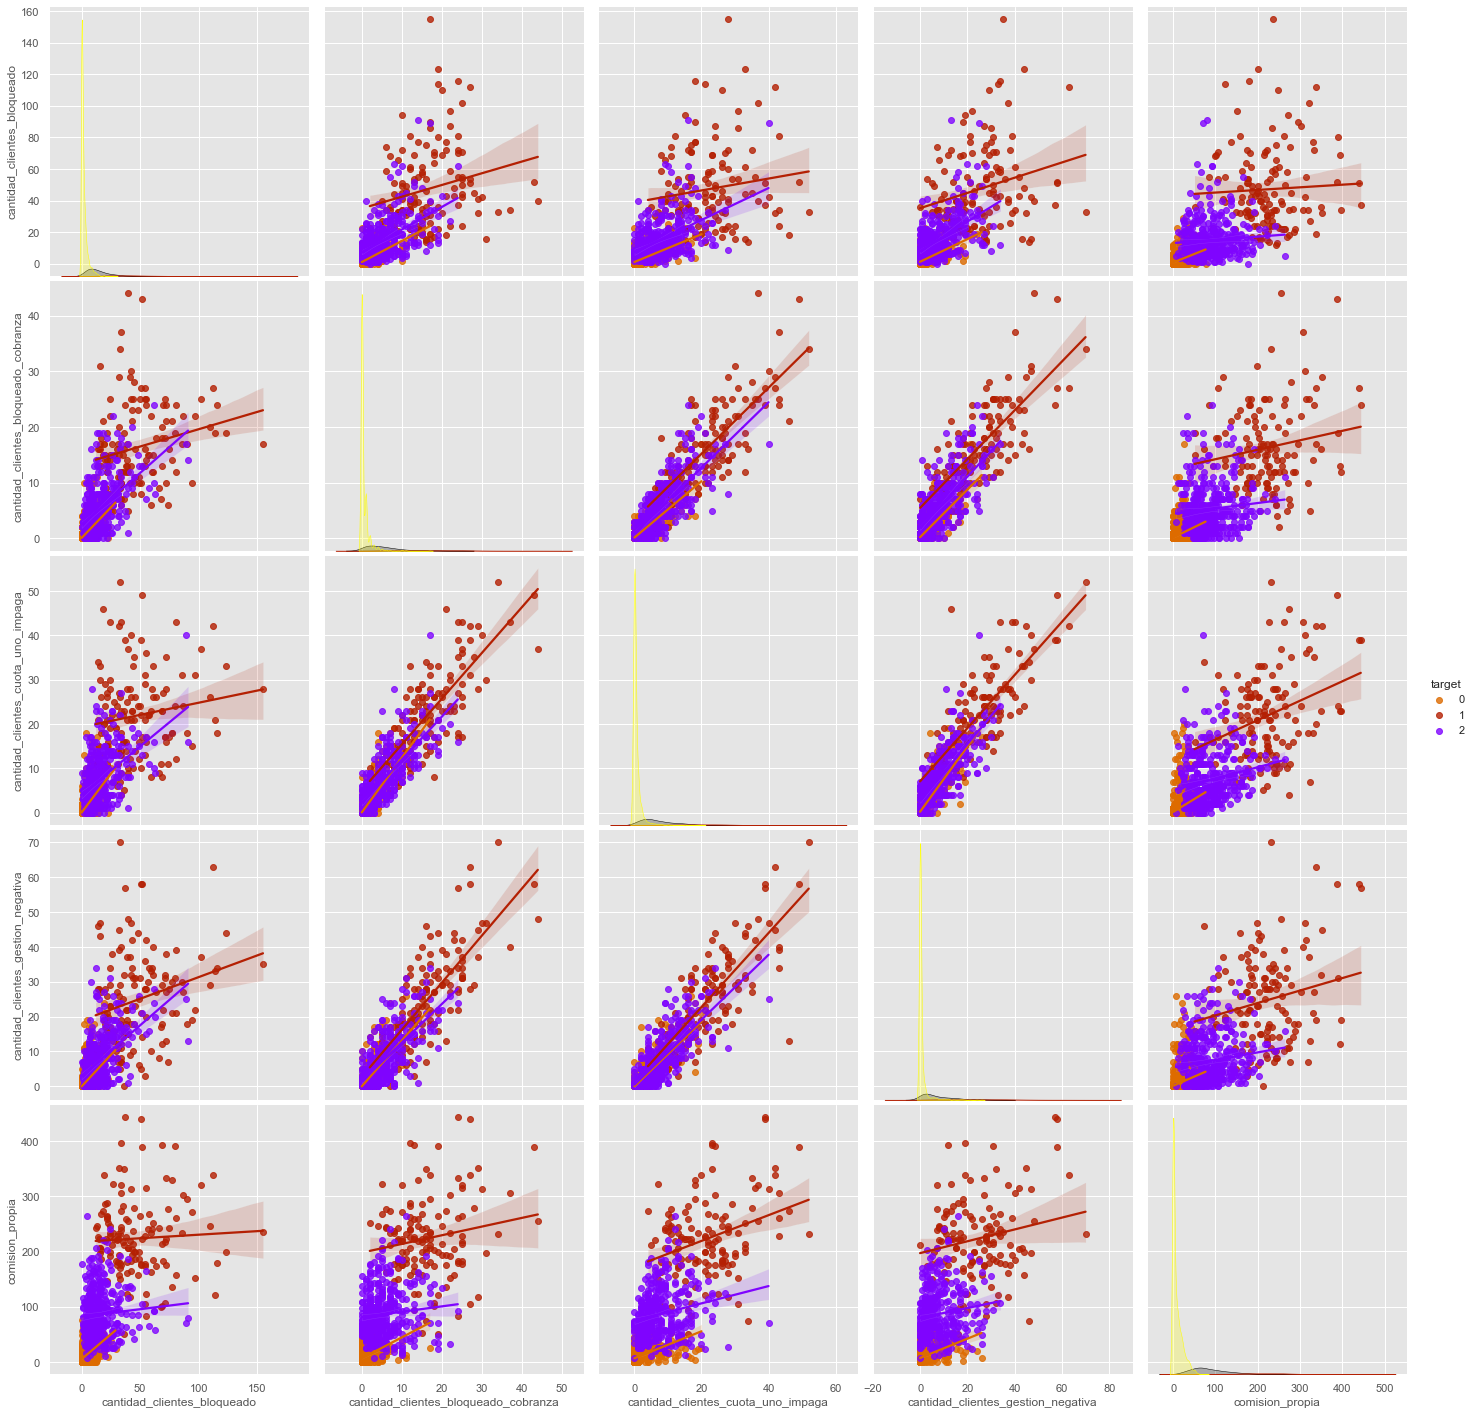

In [65]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
sns.pairplot(vista.dropna(), hue='target',
             height=4,
             vars=[ 'cantidad_clientes_bloqueado', 'cantidad_clientes_bloqueado_cobranza',
       'cantidad_clientes_cuota_uno_impaga','cantidad_clientes_gestion_negativa','comision_propia'],
             kind='reg',
             palette='gnuplot_r')